In [60]:
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import random

from lib.baseline import *
from lib.baycon import execute

from lib.CF_De.cfde import CF_Descent
from lib.cf_a.cfae import CF_Ascent
from lib.neighborSearch.cfnMarginal import neighborSearchMarginal as neighborSearch
from dataclasses import dataclass
from lib.eval.generator import run
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cross testing of methods

In [61]:
#X, true_y = load_wine(return_X_y=True)
X, true_y = load_breast_cancer(return_X_y=True)
# X, true_y = make_blobs(centers=3, cluster_std=2, n_features=2, n_samples=250)

mu = X.mean(axis=0)
sigma = X.std(axis=0)
X = (X - mu) / sigma

nc = 2
km = KMeans(n_clusters=nc)
y = km.fit_predict(X)
centers = km.cluster_centers_

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: int
    instance_label: float

n = 1
cfs = []
for i in range(n):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)
    cfs.append(CounterfactualData([], index, target, label))

## Baseline

In [62]:
from lib.baseline import baseline_explainer
from lib.baycon import baycon_explainer
from sklearn.ensemble import RandomForestClassifier

explainer = baycon_explainer
baseline_cfs = []
for cf in cfs:
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, cf.instance, target_cluster=int(cf.target))
    baseline_cfs.append(CounterfactualData(baseline_cf, cf.instance, cf.target, cf.instance_label))

Done training classifier. Score: 1.0
--- Executing... Initial Instance: 306 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (776) CFs (0)
Re-training surrogate model with data size: 776
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (28) Unique overall (28)
Generated random instances: (3718)
Predicted top: 20 Counterfactuals: 1
Found new best [ 1.78834537  1.30892872 -0.32536277  0.35290308 -0.06225268 -0.38215279
  1.16553554  1.45622569  1.726407    0.03141978  1.87542854  1.75933081
 -0.14625184  0.09191434 -1.13637238 -0.70670042 -1.02009956  0.64902877
 -0.85993571 -0.29223093 -0.38500573  0.44971593 -0.45456801  0.50162356
 -1.23438451 -0.76123687  1.46539972 -1.36439788 -0.40404995 -0.00530979], with fitness score 0.2544 (X 0.76326 Y 1.0 F 0.33333), oversampling
Known alternatives: 796
Best instance score 0.2544 (X 0.76

## Baycon

In [63]:
from lib.ext.baycon.common.Target import Target
baycon_cfs = []
modes = ['kmeans', 'model_agnostic']
run_mode = modes[1]

pred = km.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

baycon_cfs = []
for cf in cfs:
    point_idx = cf.instance
    point_pred = int(km.predict([X[point_idx]])[0])
    if run_mode == modes[0]:
        t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[1]:
        t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, point_idx)
    baycon_cfs.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

--- Executing... Initial Instance: 306 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (775) CFs (1)
Re-training surrogate model with data size: 775
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (204) Unique overall (204)
Generated random instances: (3716)
Predicted top: 20 Counterfactuals: 1
Found new best [-0.26336402 -0.8074105  -0.32536277 -0.33443548 -0.80063123 -0.98227383
 -0.71725264 -1.17770541 -0.65577745 -0.54685634  0.05770549 -1.16726436
 -0.82277019 -0.5464582  -1.13637238 -0.98461378  1.17943503 -1.52641519
 -0.85993571 -0.45764776 -0.38500573 -0.85122084  1.76203727 -0.42837367
 -0.85780676 -0.76123687  0.22299561 -1.36439788  0.62595167 -0.00530979], with fitness score 0.1266 (X 0.93067 Y 0.17 F 0.8), oversampling
Known alternatives: 795
Best instance score 0.1266 (X 0.93067 Y 0.17 F 0.8), found on epoch: 1
R

## CFDE

In [64]:
cfde_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x1, cf1, h1 = CF_Descent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        temp_cfs.append(cf1)
    cfde_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))    

cfde_cfs

[CounterfactualData(cf=[array([ 0.98649786,  0.49202131,  1.01866689,  0.97479724,  0.5871176 ,
        -0.98227383, -1.09653003, -1.17770541,  0.52619314,  0.22927434,
         0.86311672, -1.16726436,  0.86446528,  0.8137762 , -1.13637238,
         0.69281919,  0.63976499, -1.52641519,  0.13798752,  0.40384985,
         1.05221312,  0.51705679,  1.07769473,  1.01391704,  0.59804381,
         0.95285513, -1.25209839, -1.36439788,  0.5994129 ,  0.61362004]), array([ 0.98649786,  0.49202131,  1.01866689,  0.97479724,  0.5871176 ,
        -0.98227383, -1.09653003, -1.17770541,  0.60339021,  0.22927434,
         0.86311672, -1.16726436,  0.86446528,  0.8137762 , -1.13637238,
         0.69281919,  0.63976499, -1.52641519,  0.13798752,  0.40384985,
         1.05221312,  0.43174156,  1.07769473,  1.01391704,  0.59804381,
         0.95285513, -1.25209839, -1.36439788,  0.5994129 ,  0.61362004]), array([ 0.98649786,  0.49202131,  1.01866689,  0.97479724,  0.5871176 ,
        -0.98227383, -1.09

## CFAE

In [65]:
cfae_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20, center_mode=False)
        temp_cfs.append(cf2)
    cfae_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

cfae_cfs

gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming


[CounterfactualData(cf=[array([-0.26336402, -0.8074105 , -0.32536277, -0.33443548, -0.80063123,
        -0.98227383,  1.67680524,  1.8789949 , -0.65577745, -0.54685634,
         1.60203177, -1.16726436,  1.32414021,  1.9960095 , -1.13637238,
        -0.98461378, -1.02009956, -0.81205141, -0.85993571, -0.45764776,
        -0.38500573, -0.85122084, -0.45456801,  2.43780955, -0.85780676,
        -0.76123687,  1.0053131 ,  1.4088754 , -0.40404995, -0.00530979]), array([-0.26336402,  0.34611298, -0.32536277,  1.24024951, -0.80063123,
         0.74012391,  1.72165563,  1.27546994,  0.94783352, -0.54685634,
        -0.77551838, -1.16726436, -0.82277019,  0.24237069, -1.13637238,
        -0.98461378,  0.36654886, -0.28599907, -0.85993571, -0.45764776,
        -0.38500573,  0.99827402, -0.45456801,  1.11060433, -0.85780676,
         0.1608243 ,  1.1492788 ,  0.7362571 , -0.40404995, -0.00530979]), array([-0.26336402,  0.61710711, -0.32536277, -0.33443548, -0.80063123,
        -0.13086634,  0.81

## NeighborSearch

In [66]:
ns_cfs = []
for cf in cfs:
    i, new_cfs = neighborSearch(X=X, y=y, target=cf.target, kmeans=km, instance_index=cf.instance, n=15)
    ns_cfs.append(CounterfactualData(new_cfs, cf.instance, cf.target, cf.instance_label))

ns_cfs

[CounterfactualData(cf=array([[ 0.56311729, -0.8074105 ,  0.54086714,  0.44968361,  0.06047061,
          0.1773672 ,  0.07119528,  0.27111679,  0.18028859, -0.0450245 ,
          1.0817811 ,  0.20891548,  0.82518671,  0.74240195, -0.09032997,
         -0.34082217, -0.04057479, -0.02046065, -0.21700885, -0.13651237,
          0.75601901, -0.06631377,  0.64750801,  0.6195181 , -0.04245918,
         -0.76123687,  0.03843544,  0.10649142, -0.17594288, -0.1311037 ],
        [ 0.90109419, -0.51420004,  0.86626973,  0.77732423,  0.31595455,
         -0.00456701,  0.4745865 ,  0.89275176,  0.00504331, -0.94520308,
         -0.77551838, -0.65326074, -0.82277019, -0.5464582 , -0.76135717,
         -0.58394167, -0.28427891,  0.13363853, -0.79939646, -0.54199781,
          0.74152323, -0.09562565,  0.7041011 ,  0.60018106,  0.40466691,
         -0.08756491,  0.3147728 ,  1.08251632,  0.38380921, -0.15604081],
        [ 0.7534068 , -0.11394449,  0.71386598,  0.65815634, -0.80063123,
         -0.23

# Dice Mod

In [74]:
from lib.dice_mod import Gainer, gradient_ascent
from scipy.spatial.distance import pdist


dice_cfs = []
for cf in cfs:
    instance = X[cf.instance].reshape(1, -1)
    gainer = Gainer(centers, X, cf.target, instance, eps=0.2)
    dice_cf = gradient_ascent(instance, gainer.gain, max_iter=5000, dbg=True)[0]
    dice_cfs.append(CounterfactualData(dice_cf, cf.instance, cf.target, cf.instance_label))

dice_cfs

X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 2, score: 0.680732416389243, imp: 0.0001312920910379045, grad: 0.0441850952788865
iter: 3, score: 0.6808297722898468, imp: 9.735590060377941e-05, grad: 0.031524579872539586
iter: 4, score: 0.6809277255923656, imp: 9.795330251882728e-05, grad: 0.0319305829626764
iter: 5, score: 0.6810263457898043, imp: 9.862019743867023e-05, grad: 0.031500104103303145
iter: 6, score: 0.681123962337265, imp: 9.761654746076598e-05, grad: 0.03156501726047314
iter: 7, score: 0.6812216817973639, imp: 9.771946009884402e-05, grad: 0.03181894418141273
iter: 8, score: 0.6813194889557453, imp: 9.780715838147991e-05, grad: 0.03154229161065706
iter: 9, score: 0.6814176771028606, imp: 9.818814711526347e-05, grad: 0.03145414303949492
iter: 10, score: 0.6815142797563523, imp: 9.660265349165087e-05, grad: 0.03178154132041488
iter: 11, score: 0.6816126668547546, imp: 9.838709840237492e-05, grad: 0.03150901094351029
iter: 12, score: 0.6817102937836419, imp: 9.762692888726221e-05, 

[CounterfactualData(cf=array([[-0.10134293, -0.9234337 , -0.19258321, -0.20912505, -0.87998279,
         -0.98227466, -1.09653733, -1.17771516, -0.65578637, -0.61855514,
         -0.77551557, -1.85708239, -0.82276871, -0.54645618, -1.84928686,
         -1.12958964, -1.30418815, -2.05896429, -1.2683176 , -0.45764701,
         -0.28285443, -0.96009315, -0.38351378, -0.337893  , -0.9410762 ,
         -0.76123963, -1.34032111, -1.39487683, -0.40404529,  0.1952722 ]]), instance=306, target=0, instance_label=np.int32(1))]

# threshold tree / imm

In [86]:
from lib.threshold_tree import ThresholdTree

tt = ThresholdTree(km, centers, X, y)
tt_dtc_cfs = []
tt_imm_cfs = []
print(centers)
for cf in cfs:
    tt_cf = tt.find_counterfactuals_DTC(X[cf.instance], cf.target)
    cf_data = CounterfactualData(tt_cf, cf.instance, cf.target, cf.instance_label)
    tt_dtc_cfs.append(cf_data)

    tt_imm_cf = tt.find_counterfactuals_IMM(X[cf.instance], cf.target)
    cf_data = CounterfactualData(tt_imm_cf, cf.instance, cf.target, cf.instance_label)
    tt_imm_cfs.append(cf_data)



print(tt_dtc_cfs)
print(tt_imm_cfs)

[[ 0.98649786  0.49202131  1.01866689  0.97479724  0.5871176   1.014073
   1.14492245  1.17028266  0.60339021  0.22927434  0.86311672  0.04416341
   0.86446528  0.8137762   0.01228944  0.69281919  0.63976499  0.77166695
   0.13798752  0.40384985  1.05221312  0.51705679  1.07769473  1.01391704
   0.59804381  0.95285513  1.05144274  1.15328841  0.5994129   0.61362004]
 [-0.48677585 -0.24278217 -0.50264928 -0.48100231 -0.28970632 -0.50038248
  -0.56494861 -0.57746231 -0.29773585 -0.11313275 -0.42589487 -0.02179192
  -0.4265603  -0.40154836 -0.00606408 -0.34186354 -0.31568456 -0.38077004
  -0.06808833 -0.19927499 -0.51920227 -0.25513563 -0.53177588 -0.50030552
  -0.29509774 -0.47017523 -0.51882214 -0.56907669 -0.29577329 -0.30278364]]
DTC accuracy: 0.9982425307557118

[CounterfactualData(cf=array([[-0.26336402, -0.80741048, -0.32536277, -0.33443546, -0.80063123,
        -0.98227382, -1.09653008, -1.17770541, -0.65577745, -0.54685634,
        -0.77551836, -1.16726434, -0.82277018, -0.546458

## Testing

In [82]:
baseLine = {
    "name": "Baseline",
    "counterfactuals": baseline_cfs
}
Baycon = {
    "name": "Baycon",
    "counterfactuals": baycon_cfs
}
cfde = {
    "name": "CF-DE",
    "counterfactuals": cfde_cfs
}
cfae = {
    "name": "CF-AE",
    "counterfactuals": cfae_cfs
}
nfs = {
    "name": "NeighborSearch",
    "counterfactuals": ns_cfs
}
dice_mod = {
    "name": "dice_mod",
    "counterfactuals": dice_cfs
}
tt_dtc = {
    "name": "ThresholdTree_DTC",
    "counterfactuals": tt_dtc_cfs
}
tt_imm = {
    "name": "ThresholdTree_IMM",
    "counterfactuals": tt_imm_cfs
}

methods = [baseLine, Baycon, cfde, cfae, nfs, dice_mod, tt_dtc, tt_imm]
results, names = run(methods, centers, X, y)

max_name_length = max(len(m['name']) for m in methods)
mean_results = []

for i, n in enumerate(names):
    print(f"========== Mean {n} ==========")
    row = {}
    for m in methods:
        r = results[m['name']][0][i]
        try:
            r = np.mean(r)
        except:
            pass
        print(f"{m['name']:<{max_name_length}} {r:.4f}")
        row[m['name']] = r
    mean_results.append(row)

mean_results_df = pd.DataFrame(mean_results, index=names)
mean_results_df


========== Mean Similarity ==========
Baseline          7.5092
Baycon            2.6363
CF-DE             6.3394
CF-AE             6.9363
NeighborSearch    6.0364
dice_mod          1.3085
ThresholdTree_DTC 2.1687
ThresholdTree_IMM 1.4742
========== Mean Minimality ==========
Baseline          0.3444
Baycon            0.8267
CF-DE             0.2667
CF-AE             0.5133
NeighborSearch    0.1333
dice_mod          0.0000
ThresholdTree_DTC 0.0000
ThresholdTree_IMM 0.9667
========== Mean Plausibility ==========
Baseline          -1.3488
Baycon            -1.7141
CF-DE             -1.5167
CF-AE             -1.3088
NeighborSearch    -1.0350
dice_mod          -1.9410
ThresholdTree_DTC -1.7192
ThresholdTree_IMM -1.7561
========== Mean Validity ==========
Baseline          0.6667
Baycon            0.0000
CF-DE             1.0000
CF-AE             1.0000
NeighborSearch    1.0000
dice_mod          0.0000
ThresholdTree_DTC 0.0000
ThresholdTree_IMM 0.0000
========== Mean Diversity ==========
Bas

,Baseline,Baycon,CF-DE,CF-AE,NeighborSearch,dice_mod,ThresholdTree_DTC,ThresholdTree_IMM
Similarity,7.509156,2.636342e+00,6.339424e+00,6.936340,6.036378,1.308469,2.168745,1.474216
Minimality,0.344444,8.266667e-01,2.666667e-01,0.513333,0.133333,0.000000,0.000000,0.966667
Plausibility,-1.348813,-1.714110e+00,-1.516701e+00,-1.308779,-1.034995,-1.941026,-1.719172,-1.756052
Validity,0.666667,0.000000e+00,1.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000
Diversity,1.211616,8.426112e-07,1.281145e-16,0.871370,0.403569,1.076734,0.007388,1.067054


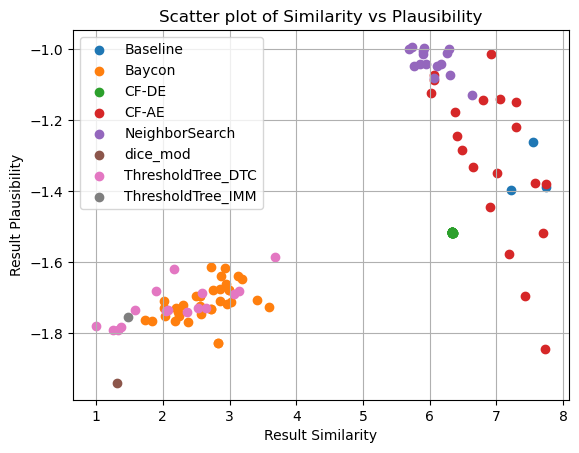

In [83]:
def plot(f1, f2, methods, results, names):
    for idx, m in enumerate(methods):
        res = results[m['name']]
        result_x = [row[f1] for row in res]
        result_y = [row[f2] for row in res]

        plt.scatter(result_x, result_y, label=f"{m['name']}")

    # Adding title and labels
    plt.title(f"Scatter plot of {names[f1]} vs {names[f2]}")
    plt.xlabel(f"Result {names[f1]}")
    plt.ylabel(f"Result {names[f2]}")
    plt.grid(True)

    # Show the legend to distinguish between different datasets
    plt.legend()
    plt.show()

plot(0,2, methods, results, names)

<Axes: >

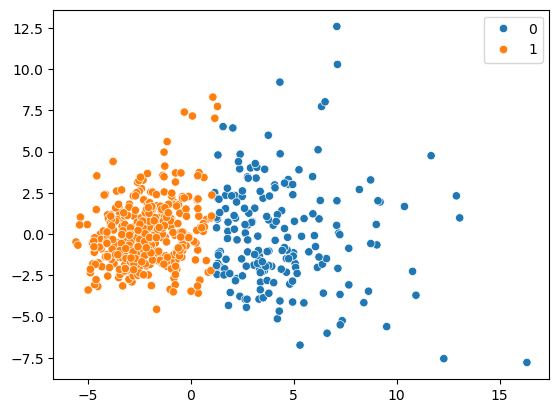

In [84]:
pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)

CounterfactualData(cf=array([[ 0.18824688,  0.19633931,  1.48925311,  1.49983808, -0.80063123,
         1.01907411,  1.52416187,  1.67311036, -0.65577745, -0.54685634,
         0.77902416, -1.16726436,  1.34551696,  0.75829332, -1.13637238,
        -0.98461378, -1.02009956, -1.52641519, -0.95630224, -0.45764776,
         1.06358416,  0.51396106, -0.45456801, -0.42837367,  1.16766102,
         0.97206245, -0.38227819,  0.67991538,  0.25038067, -0.00530979],
       [-0.26336402, -0.8074105 ,  0.80667877, -0.33443548, -0.43576877,
         0.79615165,  0.92645133,  1.30130806,  1.00978523,  1.79092725,
        -0.83672966, -1.16726436, -0.82277019,  0.41361454, -1.13637238,
         1.26617159, -0.47679288,  1.23624528, -0.85993571,  0.82798765,
         0.15640943, -0.85122084, -0.45456801,  1.44585613,  0.83404359,
         0.15678427,  0.50970425,  1.00368462, -0.28167825,  1.48360002],
       [-0.26336402,  1.8325002 ,  0.83770487, -0.33443548,  1.33843266,
         0.70061345,  0.059

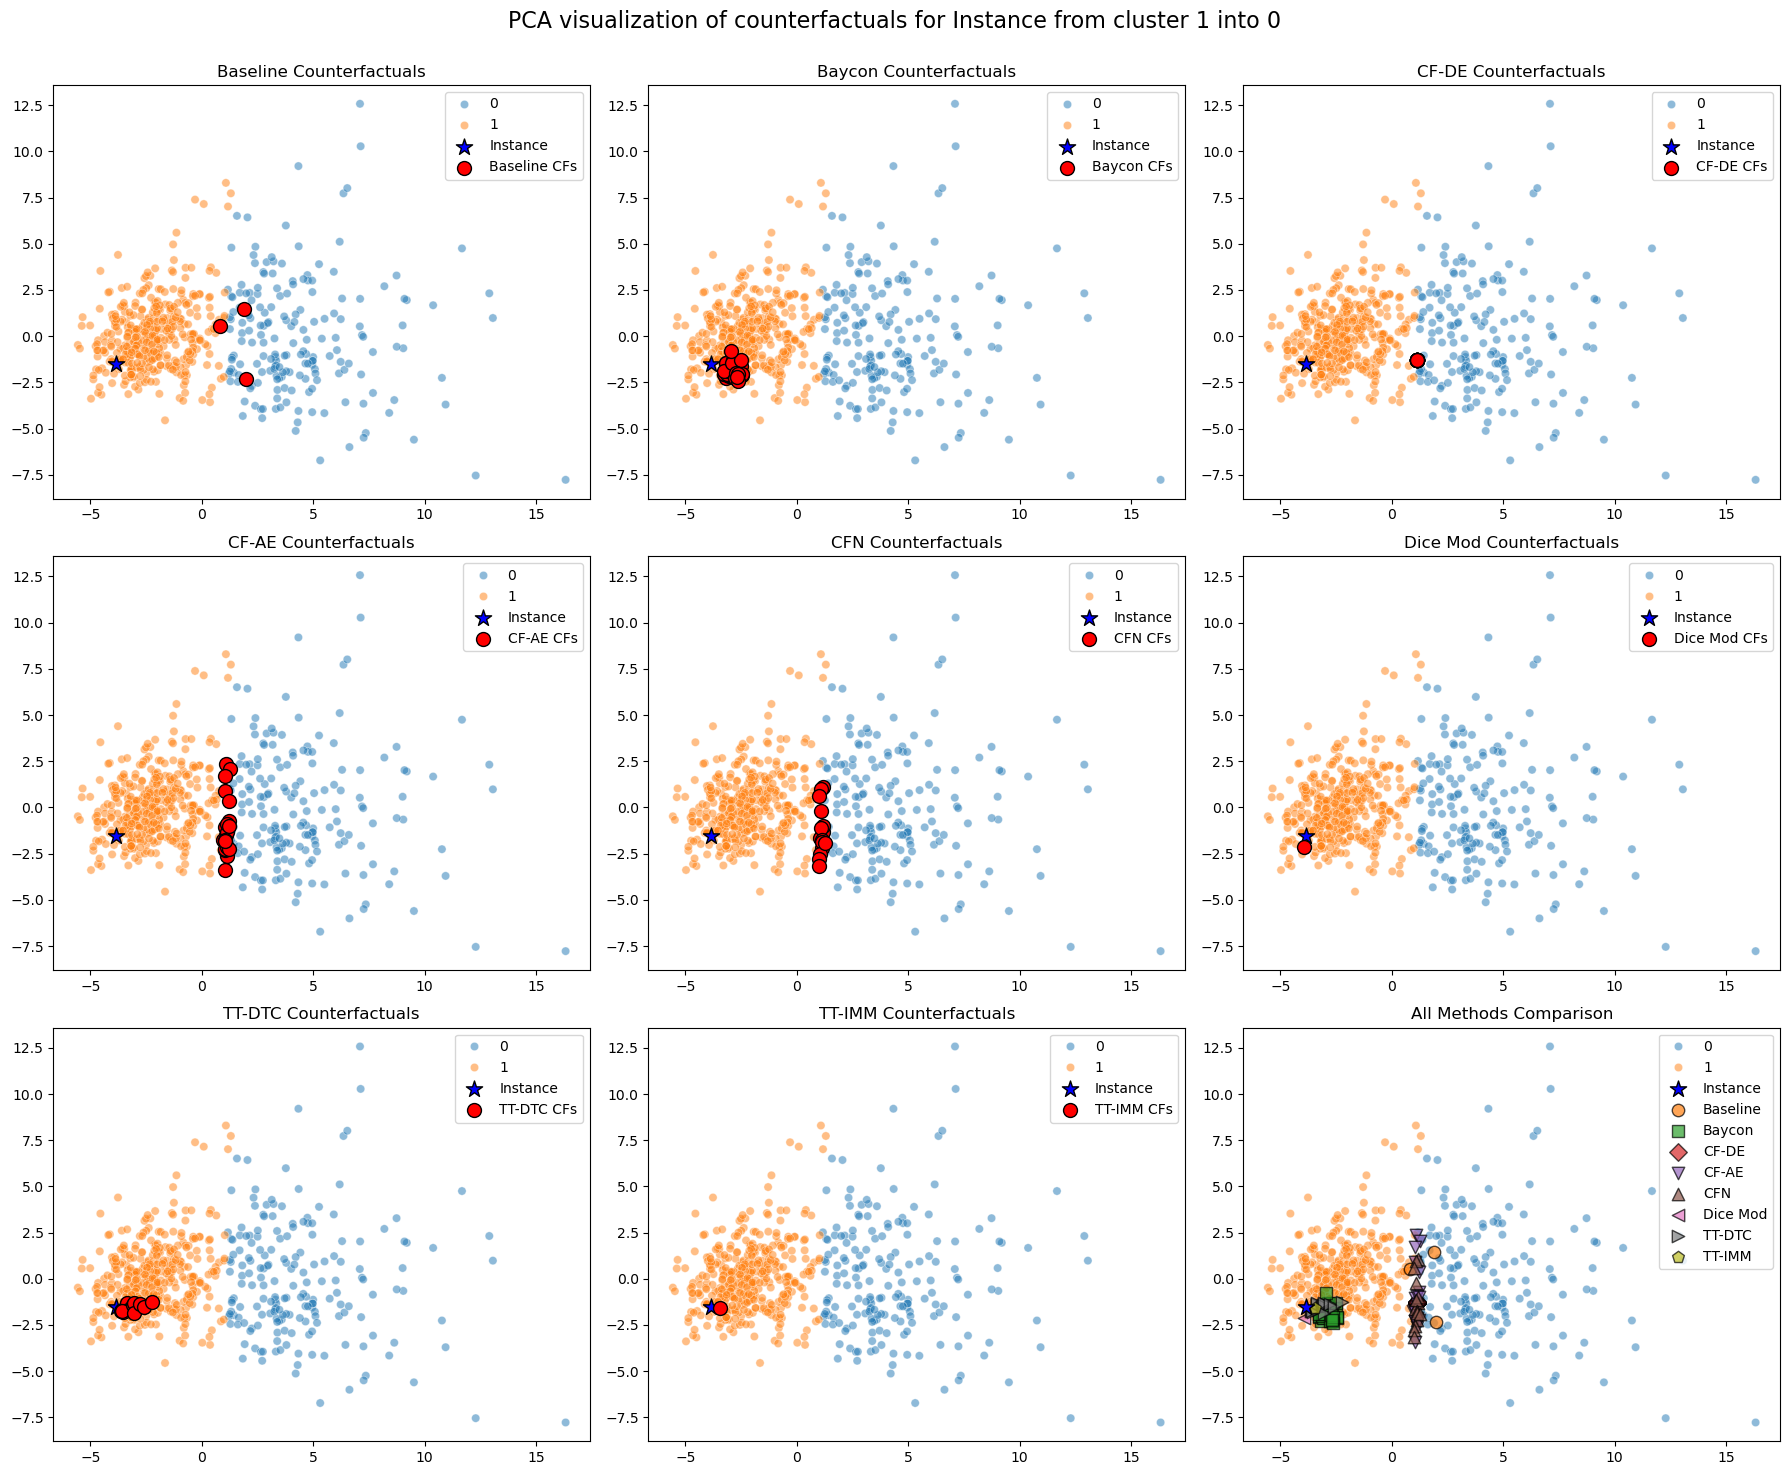

In [ ]:
cf_n = 0
cf_n = 0

fig, axs = plt.subplots(3, 3, figsize=(18, 15))
axs = axs.flatten()

# Transform data with PCA
baseline_embed = pca.transform(baseline_cfs[cf_n].cf)
baycon_embed = pca.transform(baycon_cfs[cf_n].cf)
cfde_embed = pca.transform(np.array(cfde_cfs[cf_n].cf))
cfae_embed = pca.transform(np.array(cfae_cfs[cf_n].cf))
cfn_embed = pca.transform(np.array(ns_cfs[cf_n].cf))
dice_embed = pca.transform(dice_cfs[cf_n].cf)
tt_dtc_embed = pca.transform(tt_dtc_cfs[cf_n].cf)
tt_imm_embed = pca.transform(tt_imm_cfs[cf_n].cf)
instance_embedded = pca.transform(X[[baseline_cfs[cf_n].instance]])

ins_c = baseline_cfs[cf_n].instance_label
target_c = baseline_cfs[cf_n].target

# Base scatterplot of the data
for i in range(8):
    sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[i])
    axs[i].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
                  marker='*', label='Instance', zorder=5, edgecolor='black')

# Plot each method's counterfactuals
methods = [
    ('Baseline', baseline_embed),
    ('Baycon', baycon_embed),
    ('CF-DE', cfde_embed),
    ('CF-AE', cfae_embed),
    ('CFN', cfn_embed),
    ('Dice Mod', dice_embed),
    ('TT-DTC', tt_dtc_embed),
    ('TT-IMM', tt_imm_embed)
]

for i, (name, embed) in enumerate(methods):
    axs[i].scatter(embed[:, 0], embed[:, 1], color='red', s=100, 
                 marker='o', label=f'{name} CFs', zorder=5, edgecolor='black')
    axs[i].set_title(f"{name} Counterfactuals")
    axs[i].legend(loc='upper right')

# Add a global title
fig.suptitle(f"PCA visualization of counterfactuals for Instance from cluster {ins_c} into {int(target_c)}", 
            fontsize=16, y=0.98)

# Final subplot for combined view
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[8])
axs[8].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
              marker='*', label='Instance', zorder=5, edgecolor='black')

# Add all counterfactuals with different markers
markers = ['o', 's', 'D', 'v', '^', '<', '>', 'p']
for i, (name, embed) in enumerate(methods):
    axs[8].scatter(embed[:, 0], embed[:, 1], marker=markers[i], label=name, s=80, 
                 alpha=0.7, edgecolor='black')
axs[8].set_title("All Methods Comparison")
axs[8].legend(loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


## Running time

In [36]:
import time
baseline_rt = 0.0
baycon_rt = 0.0
cfde_rt = 0.0
cfae_rt = 0.0
ns_rt = 0.0

it_rt = 5
for _ in range(it_rt):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)

    timestamp = time.time()
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, index, target_cluster=int(target))
    baseline_rt += time.time() - timestamp

    timestamp = time.time()
    t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))
    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, model, t, index)
    baycon_rt += time.time() - timestamp

    timestamp = time.time()
    x1, cf1, h1 = CF_Descent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20)
    cfde_rt += time.time() - timestamp

    timestamp = time.time()
    x2, cf2, h2 = CF_Ascent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20, center_mode=False)
    cfae_rt += time.time() - timestamp

    timestamp = time.time()
    i_t, new_cfs_t = neighborSearch(X=X, y=y, target=target, kmeans=km, instance_index=index, n=10)
    ns_rt += time.time() - timestamp

baseline_rt /= it_rt
baycon_rt /= it_rt
cfde_rt /= it_rt
cfae_rt /= it_rt
ns_rt /= it_rt

print(f"Baseline: {baseline_rt}")
print(f"Baycon:   {baycon_rt}")
print(f"CFDE:     {cfde_rt}")
print(f"CFAE:     {cfae_rt}")
print(f"CFN:     {ns_rt}")


Done training classifier. Score: 1.0
--- Executing... Initial Instance: 184 Target: 1 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (183) CFs (2)
Re-training surrogate model with data size: 183
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (0) Unique overall (0)
Generated random instances: (133)
Predicted top: 20 Counterfactuals: 20
Known alternatives: 203
Best instance score 0.4633 (X 0.92658 Y 1.0 F 0.5), found on epoch: 0
Re-training surrogate model with data size: 203
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (3) Unique overall (3)
Generated random instances: (113)
Predicted top: 20 Counterfactuals: 20
Known alternatives: 223
Best instance score 0.4633 (X 0.92658 Y 1.0 F 0.5), found on epoch: 0
Re-training surrogate model with data size: 223
--- epoch 3 ----
Generating neighbors for 20

NameError: name 'model' is not defined

## RD-CFAE vs CFAE
*rd is random-direction

In [ ]:
n = 1
cfs_div = []
for i in range(n):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)
    
    cfs_div.append(CounterfactualData([], index, float(target), label))

amount = 70

cfae_cfs_div = []
for cf in cfs_div:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        temp_cfs.append(cf2)
    cfae_cfs_div.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

rd_cfae_cfs_div = []
for cf in cfs_div:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20, center_mode=False)
        temp_cfs.append(cf2)
    rd_cfae_cfs_div.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

In [ ]:
cf_n = 0
cfae_embed = [pca.transform(v.cf) for v in cfae_cfs_div][cf_n]
rd_cfae_embed = [pca.transform(v.cf) for v in rd_cfae_cfs_div][cf_n]
instance_embedded = pca.transform(X[[cfae_cfs_div[cf_n].instance]])

ins_c = cfae_cfs_div[cf_n].instance_label
target_c = cfae_cfs_div[cf_n].target

plt.title(f"Instance from cluster {ins_c} into {int(target_c)}")
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)
sns.scatterplot(x=rd_cfae_embed[:,0], y=rd_cfae_embed[:,1], label="RD-CFAE counterfactuals")
sns.scatterplot(x=cfae_embed[:,0], y=cfae_embed[:,1], label="CFAE counterfactuals")
sns.scatterplot(x=instance_embedded[:,0], y=instance_embedded[:,1], label="Instance", color="blue")